In [3]:
import numpy as np
import torch
import torch.nn as nn

# Generate time-series traffic volume data
np.random.seed(0)
x = np.arange(0, 1000, 1)
y = np.zeros(len(x))

# Add a pattern to the data
for i in range(len(x)):
    y[i] = 2000 * np.sin(2*np.pi/24 * i) + 4000

# Split data into training and testing sets
train_ratio = 0.8
train_size = int(len(x)*train_ratio)
train_x, train_y = x[:train_size], y[:train_size]
test_x, test_y = x[train_size:], y[train_size:]

# Normalize the data
train_x = (train_x - min(train_x)) / (max(train_x) - min(train_x))
train_y = train_y / max(train_y)
test_x = (test_x - min(test_x)) / (max(test_x) - min(test_x))
test_y = test_y / max(test_y)

# Convert data to PyTorch tensors
train_x = torch.from_numpy(train_x.reshape(-1, 1)).float()
train_y = torch.from_numpy(train_y.reshape(-1, 1)).float()
test_x = torch.from_numpy(test_x.reshape(-1, 1)).float()
test_y = torch.from_numpy(test_y.reshape(-1, 1)).float()

# Define the model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model
net = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = net(train_x)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")

# Test the model
net.eval()
with torch.no_grad():
    y_pred = net(test_x)
    y_pred = y_pred.numpy() * max(y)
    test_y = test_y.numpy() * max(y)
    for i in range(len(y_pred)):
        print("Actual traffic volume: {:.1f}, predicted traffic volume: {:.1f}".format(float(test_y[i]), float(y_pred[i][0])))


Epoch 1, loss: 0.3919
Epoch 1001, loss: 0.0558
Epoch 2001, loss: 0.0558
Epoch 3001, loss: 0.0557
Epoch 4001, loss: 0.0557
Epoch 5001, loss: 0.0557
Epoch 6001, loss: 0.0557
Epoch 7001, loss: 0.0557
Epoch 8001, loss: 0.0557
Epoch 9001, loss: 0.0557
Actual traffic volume: 5732.1, predicted traffic volume: 3930.2
Actual traffic volume: 5414.2, predicted traffic volume: 3938.3
Actual traffic volume: 5000.0, predicted traffic volume: 3946.5
Actual traffic volume: 4517.6, predicted traffic volume: 3954.6
Actual traffic volume: 4000.0, predicted traffic volume: 3962.8
Actual traffic volume: 3482.4, predicted traffic volume: 3971.0
Actual traffic volume: 3000.0, predicted traffic volume: 3979.1
Actual traffic volume: 2585.8, predicted traffic volume: 3987.3
Actual traffic volume: 2267.9, predicted traffic volume: 3995.4
Actual traffic volume: 2068.1, predicted traffic volume: 4003.6
Actual traffic volume: 2000.0, predicted traffic volume: 4011.8
Actual traffic volume: 2068.1, predicted traffic 

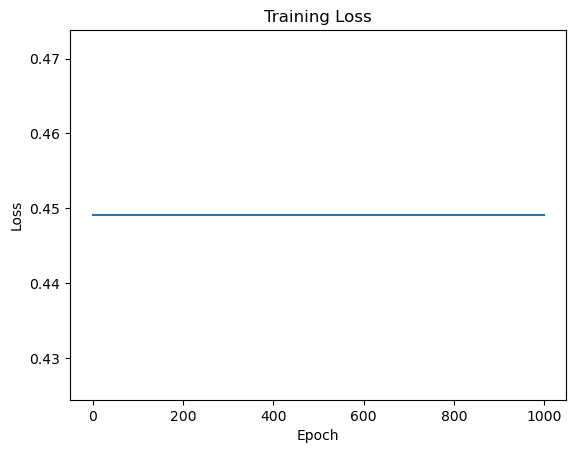

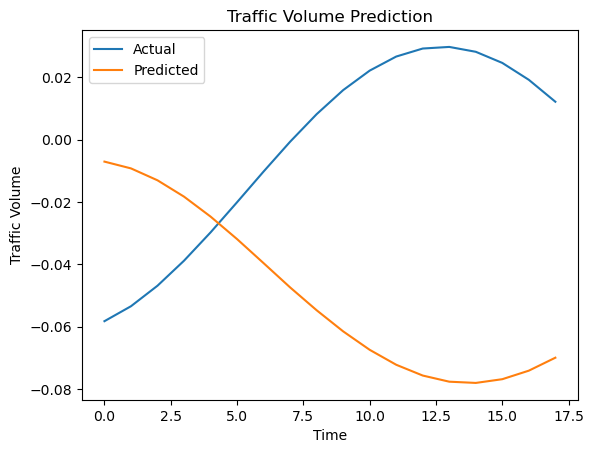

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# generate traffic volume data with pattern
t = np.arange(0, 10, 0.1)
x = np.sin(t) + np.sin(2*t)
y = x[1:] - x[:-1]

# split data into train and test sets
train_X, train_y = torch.Tensor(y[:80]).unsqueeze(1), torch.Tensor(y[1:81]).unsqueeze(1)
test_X, test_y = torch.Tensor(y[80:-1]).unsqueeze(1), torch.Tensor(y[81:]).unsqueeze(1)

# normalize the data
X_max = torch.max(train_X)
train_X = train_X / X_max
test_X = test_X / X_max
y_max = torch.max(train_y)
train_y = train_y / y_max

# define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# train the model
net = Net()
losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = net(train_X)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# plot the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the model on test set
y_pred = net(test_X).detach().numpy() * y_max.numpy()
test_y = test_y.numpy() * y_max.numpy()

# plot the actual and predicted values on a line chart
plt.plot(test_y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Traffic Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/hourly-boston-traffic/hourly_volume_boston.csv",
                 usecols=['datetime', 'volume'], parse_dates=['datetime'], index_col=['datetime'])

# Resample to hourly data
df = df.resample('H').sum()

# Split data into train and test sets
train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

# Normalize data
train_mean = train_data.mean()
train_std = train_data.std()
train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# Define input and output sequences
seq_length = 24
train_seq = [train_data.iloc[i:i+seq_length].values for i in range(len(train_data)-seq_length)]
train_label = [train_data.iloc[i+seq_length].values for i in range(len(train_data)-seq_length)]
train_seq = torch.tensor(train_seq, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)

# Define network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(10*22, 1)
        
    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Define hyperparameters and train the network
num_epochs = 100
batch_size = 128
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_seq, train_label),
                                           batch_size=batch_size, shuffle=True)

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, loss: {loss.item():.4f}")

# Evaluate the trained network on test data
net.eval()
test_seq = [test_data.iloc[i:i+seq_length].values for i in range(len(test_data)-seq_length)]
test_label = [test_data.iloc[i+seq_length].values for i in range(len(test_data)-seq_length)]
test_seq = torch.tensor(test_seq, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)
test_pred = net(test_seq).detach().numpy()

# Plot predictions against actual values
test_pred = test_pred * train_std + train_mean
test_label = test_label * train_std + train_mean
plt.plot(test_pred, label='predicted')
plt.plot(test_label, label='actual')
plt.legend()
plt.show()


HTTPError: HTTP Error 404: Not Found

In [11]:
import pandas as pd
import numpy as np
import torch

# Load traffic dataset from UCI Machine Learning Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv'
traffic_df = pd.read_csv(url)

# Convert date_time column to datetime object
traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])

# Sort dataframe by date_time
traffic_df.sort_values(by=['date_time'], inplace=True)

# Extract hour of day and day of week from date_time
traffic_df['hour'] = traffic_df['date_time'].dt.hour
traffic_df['dayofweek'] = traffic_df['date_time'].dt.dayofweek

# Convert hour and dayofweek columns to one-hot encoded features
traffic_df = pd.concat([traffic_df, pd.get_dummies(traffic_df['hour'], prefix='hour')], axis=1)
traffic_df = pd.concat([traffic_df, pd.get_dummies(traffic_df['dayofweek'], prefix='dayofweek')], axis=1)

# Define input and output columns
input_cols = ['hour_' + str(i) for i in range(24)] + ['dayofweek_' + str(i) for i in range(7)]
output_col = 'traffic_volume'

# Convert dataframe to numpy arrays
X = traffic_df[input_cols].values.astype(np.float32)
y = traffic_df[output_col].values.astype(np.float32)

# Normalize input data
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Split data into train and test sets
train_ratio = 0.8
train_size = int(len(X) * train_ratio)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Convert data to PyTorch tensors
train_X = torch.from_numpy(train_X).unsqueeze(2)
train_y = torch.from_numpy(train_y)
test_X = torch.from_numpy(test_X).unsqueeze(2)
test_y = torch.from_numpy(test_y)

# Define neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1d = torch.nn.Conv1d(1, 10, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(240, 100)
        self.fc2 = torch.nn.Linear(100, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Train neural network model
net = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = net(train_X)
    loss = criterion(output.squeeze(), train_y)
    loss.backward()
    optimizer.step()
    print('Epoch {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Evaluate trained model on test data
with torch.no_grad():
    test_output = net(test_X)
    test_loss = criterion(test_output.squeeze(), test_y)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte